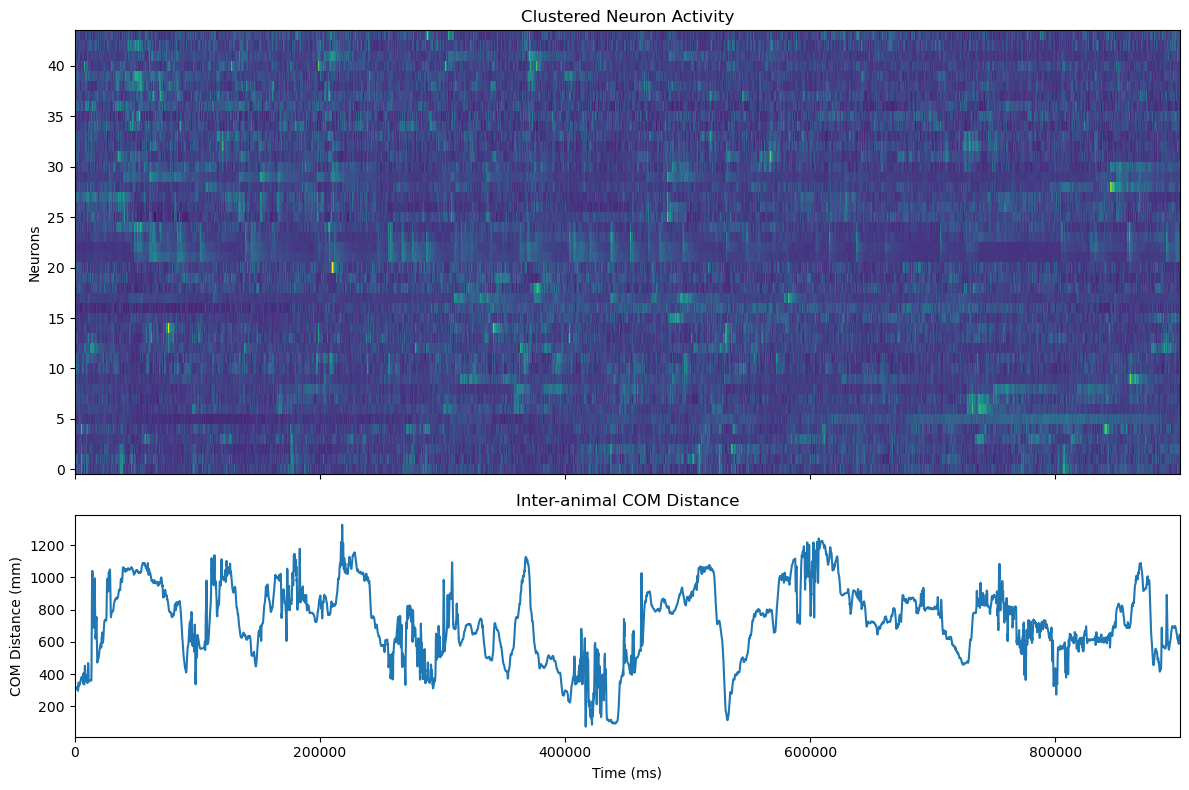

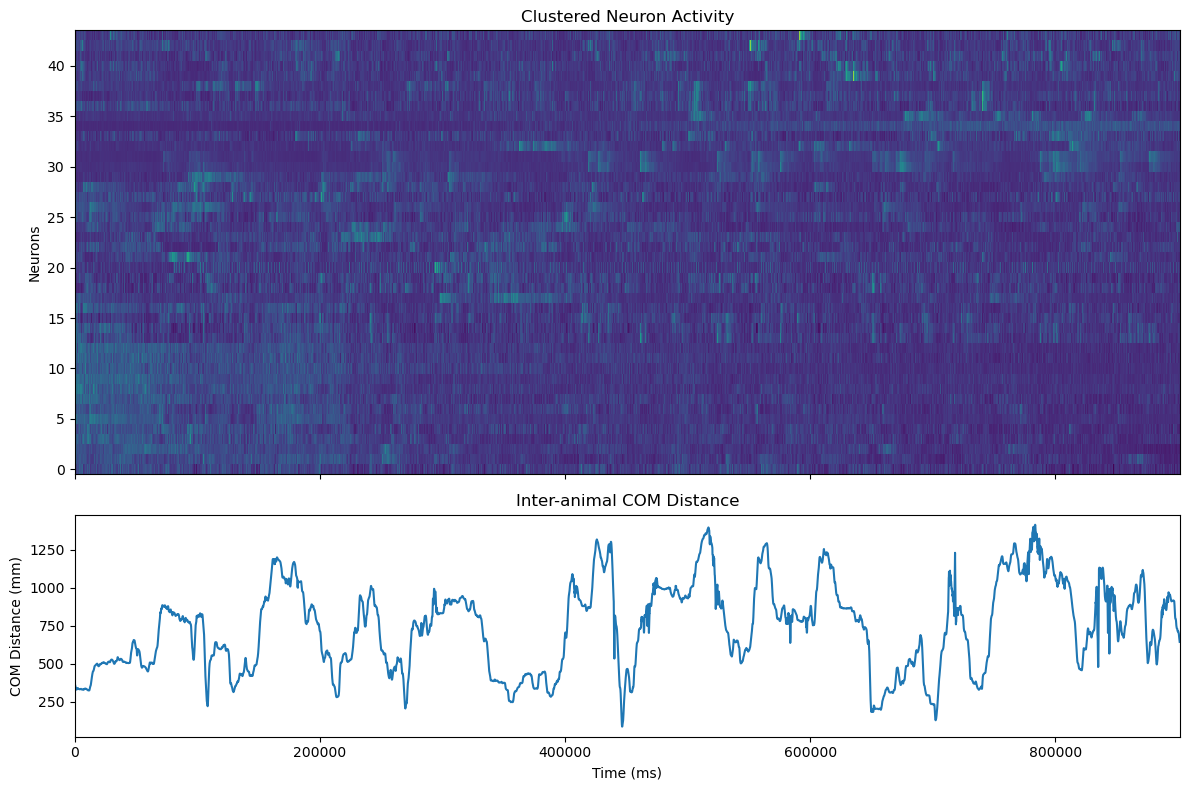

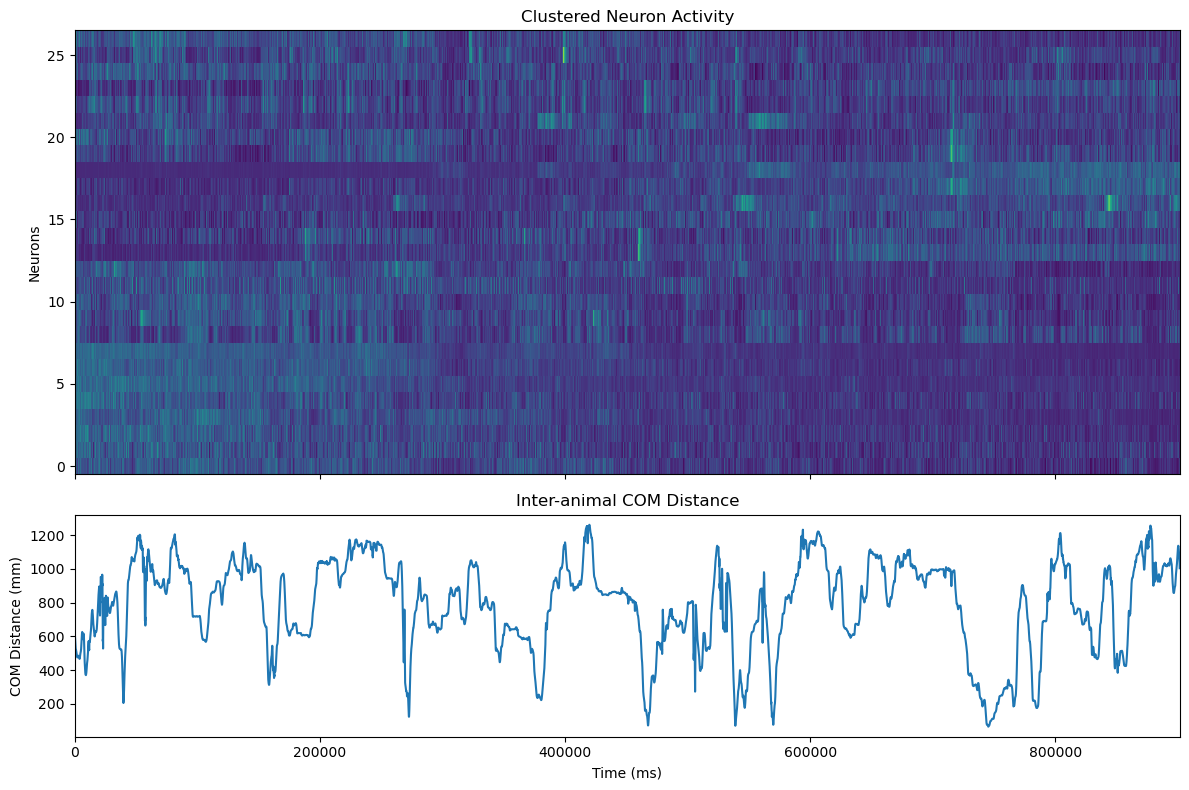

In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5 into a DataFrame
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 in {h5_dir}")
    hdf5_file = h5_files[0]
    df = pd.read_hdf(hdf5_file, key='df')
    df['session_id']     = os.path.basename(os.path.normpath(rec_path))
    df['recording_date'] = os.path.basename(os.path.dirname(rec_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(rec_path)))
    df['session_path']   = rec_path
    df['file_path']      = hdf5_file
    return df

# ----------------------------------------------------------------------------
# 3. Extract, filter & z-score neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    all_neurons = [c for c in df.columns if c.startswith('dF_F_roi')]
    keep_neurons = [n for n in all_neurons if int(n.split('_')[-1][3:]) not in excluded]
    data = df[keep_neurons].values.T
    variances = np.var(data, axis=1)
    thresh = np.percentile(variances, 5)
    keep_mask = variances > thresh
    filtered = data[keep_mask, :]
    normed = zscore(filtered, axis=1)
    kept_cols = [col for col, k in zip(keep_neurons, keep_mask) if k]
    return normed, kept_cols, df.reset_index()

# ----------------------------------------------------------------------------
# 4. Plot only clustered neurons + COM distance
# ----------------------------------------------------------------------------
def plot_cluster_and_distance(
    df, exclude_dict=None, manual_exclude_indices=None,
    apply_exclusion=True, smooth_window=5
):
    neuron_norm, _, df2 = process_neuron_activity(
        df, exclude_dict, manual_exclude_indices, apply_exclusion
    )
    time = df2['timestamp_ms_mini']

    # identify COM prefixes (e.g. 'com3d0', 'com3d1')
    prefixes = sorted({c.split('_')[0] for c in df2.columns if c.startswith('com')})
    if len(prefixes) < 2:
        raise ValueError("Need ≥2 COM prefixes to compute distance")

    p1, p2 = prefixes[:2]
    dx = df2[f'{p1}_x'] - df2[f'{p2}_x']
    dy = df2[f'{p1}_y'] - df2[f'{p2}_y']
    dz = df2[f'{p1}_z'] - df2[f'{p2}_z']
    dist = np.sqrt(dx**2 + dy**2 + dz**2)

    # apply centered moving average
    if smooth_window > 1:
        dist = dist.rolling(window=smooth_window, center=True).mean()

    # create figure
    fig, (ax0, ax1) = plt.subplots(
        2, 1, sharex=True, figsize=(12, 8),
        gridspec_kw={'height_ratios': [2, 1]}
    )

    # heatmap of clustered neuron activity
    if neuron_norm.size:
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data = neuron_norm[order, :]
        mesh = ax0.pcolormesh(time, np.arange(data.shape[0]), data,
                              cmap='viridis', shading='auto')
        ax0.set_ylabel('Neurons')
        ax0.set_title('Clustered Neuron Activity')
    else:
        ax0.set_title('No neuron activity to display')

    # COM distance trace
    ax1.plot(time, dist)
    ax1.set_ylabel('COM Distance (mm)')
    ax1.set_xlabel('Time (ms)')
    ax1.set_title('Inter-animal COM Distance')

    plt.tight_layout()
    plt.show()

    # # save to disk
    # out_dir  = os.path.join(df2['session_path'].iloc[0], 'MIR_Aligned')
    # fname    = f"cluster_distance_{df2['session_id'].iloc[0]}.png"
    # out_path = os.path.join(out_dir, fname)
    # fig.savefig(out_path, dpi=300)
    # print(f"Saved plot → {out_path}")

# ----------------------------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------------------------
session_paths = [
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
]


for path in session_paths:
    df_s = load_session_data(path)
    plot_cluster_and_distance(
        df_s,
        exclude_dict=exclude_dict,
        apply_exclusion=False   # or True if you want to apply your manual exclusions
    )


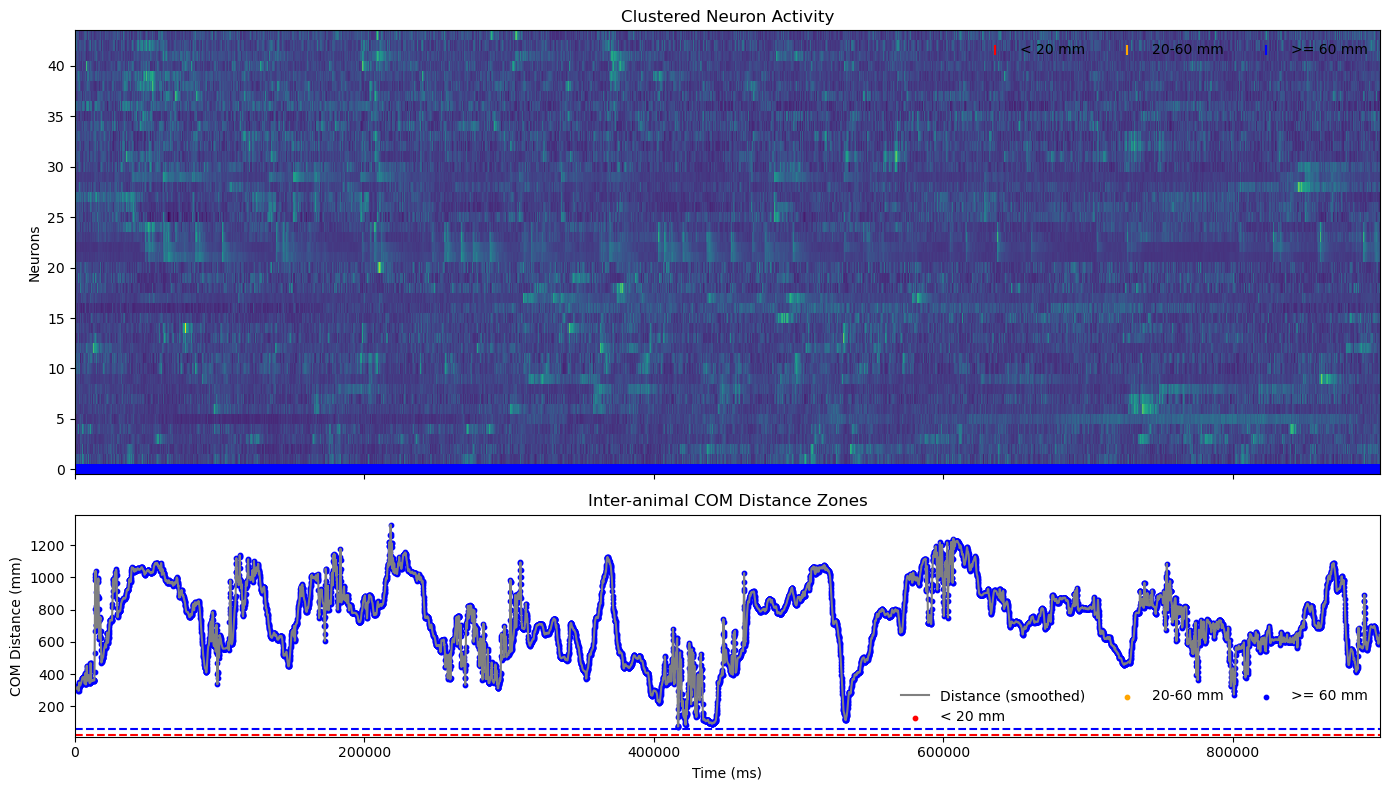

Saved → /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/MIR_Aligned/three_zone_interaction_.png


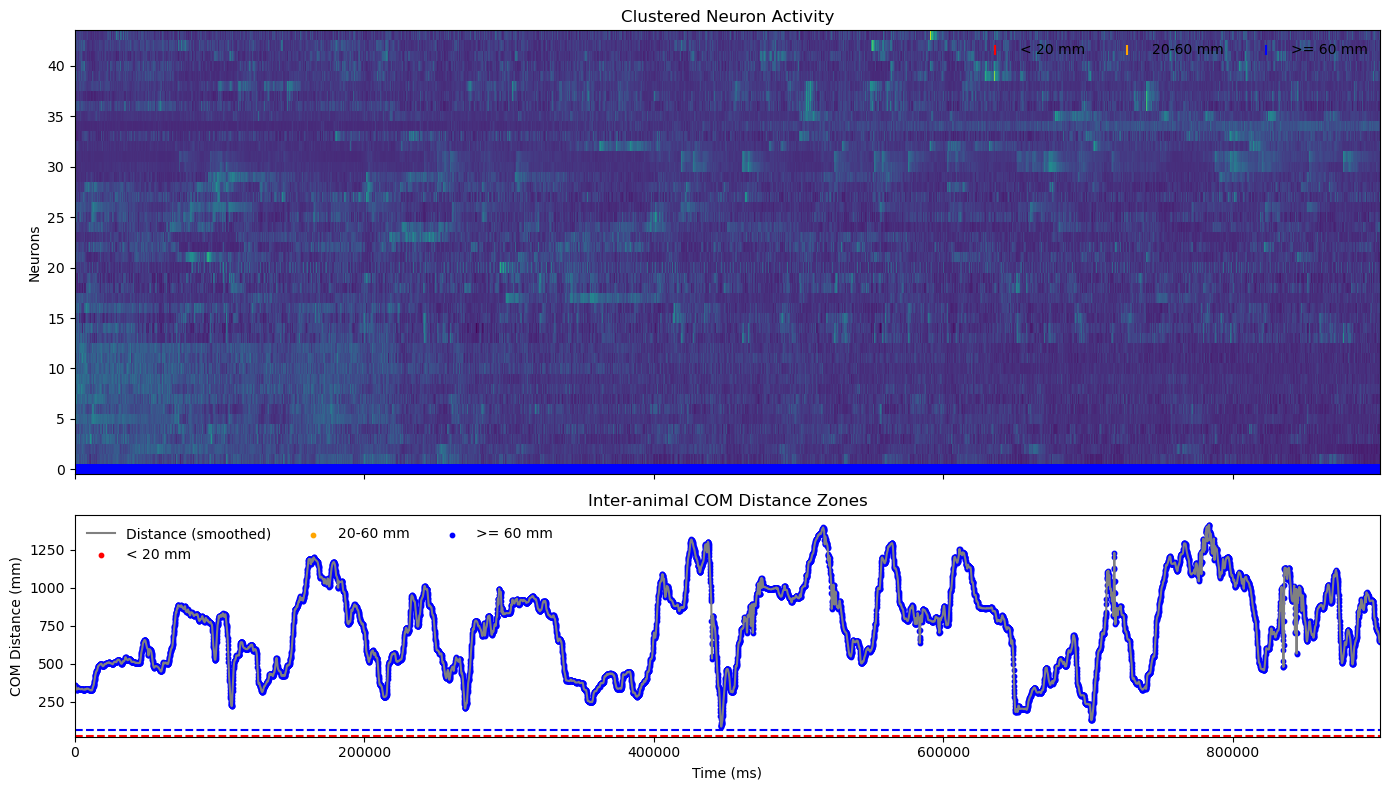

Saved → /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/MIR_Aligned/three_zone_interaction_.png


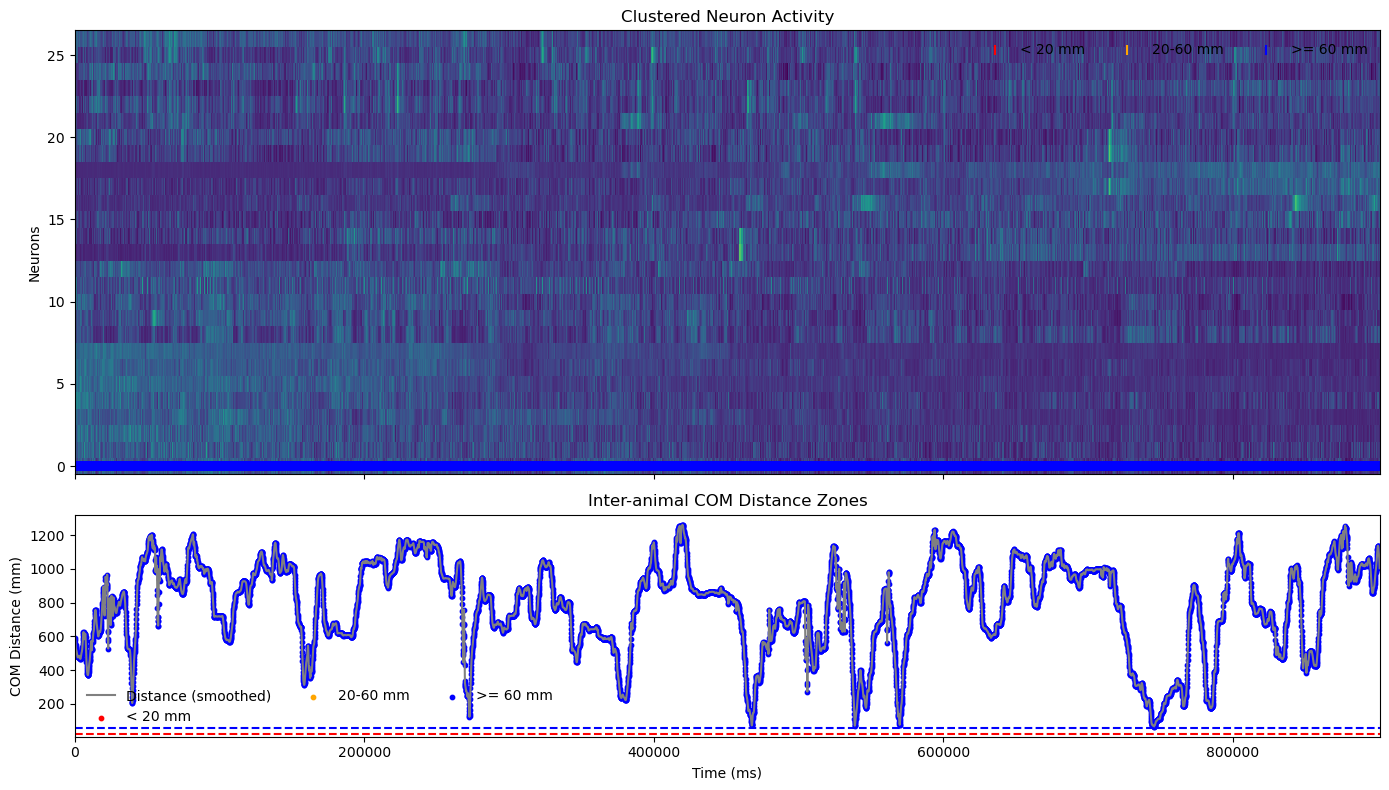

Saved → /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/MIR_Aligned/three_zone_interaction_.png


In [ ]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping (unchanged)
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5 (unchanged)
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    files = glob.glob(os.path.join(h5_dir, pattern))
    if not files:
        raise FileNotFoundError(f"No matching HDF5 in {h5_dir}")
    df = pd.read_hdf(files[0], key='df')
    df['session_path'] = rec_path
    df['file_path']    = files[0]
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity (unchanged)
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    all_neurons = [c for c in df.columns if c.startswith('dF_F_roi')]
    keep = [n for n in all_neurons 
            if int(n.split('_')[-1][3:]) not in excluded]
    data = df[keep].values.T
    variances = np.var(data, axis=1)
    p05 = np.percentile(variances, 5)
    mask = variances > p05
    filtered = data[mask, :]
    normed   = zscore(filtered, axis=1)
    cols_kept = [col for col, m in zip(keep, mask) if m]
    return normed, cols_kept, df.reset_index()

# ----------------------------------------------------------------------------
# 4. Plot with three distance categories
# ----------------------------------------------------------------------------
def plot_three_zone_interaction(
    df,
    low_threshold_mm=20,
    high_threshold_mm=60,
    smooth_window=5,
    exclude_dict=None,
    apply_exclusion=True
):
    # Neuron processing
    neuron_norm, _, df2 = process_neuron_activity(
        df, exclude_dict, apply_exclusion=apply_exclusion
    )
    time = df2['timestamp_ms_mini']

    # Compute inter-COM distance
    prefixes = sorted({c.split('_')[0] for c in df2.columns if c.startswith('com')})
    if len(prefixes) < 2:
        raise ValueError("At least two COM prefixes required")
    p1, p2 = prefixes[:2]
    coords = df2[[f'{p1}_x', f'{p1}_y', f'{p1}_z']].values \
           - df2[[f'{p2}_x', f'{p2}_y', f'{p2}_z']].values
    dist = np.linalg.norm(coords, axis=1)
    dist_sm = pd.Series(dist).rolling(window=smooth_window, center=True).mean()

    # Classify into three zones
    is_close  = dist_sm < low_threshold_mm
    is_mid    = (dist_sm >= low_threshold_mm) & (dist_sm < high_threshold_mm)
    is_far    = dist_sm >= high_threshold_mm

    # Set up figure
    fig, (ax0, ax1) = plt.subplots(
        2, 1, sharex=True, figsize=(14, 8),
        gridspec_kw={'height_ratios': [2, 1]}
    )

    # 4a. Heatmap with zone markers
    if neuron_norm.size:
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data = neuron_norm[order, :]
        ax0.pcolormesh(time, np.arange(data.shape[0]), data,
                       cmap='viridis', shading='auto')
        ax0.set_ylabel('Neurons')
        ax0.set_title('Clustered Neuron Activity')

        # add colored ticks at bottom for each zone
        for mask, color, label in [
            (is_close, 'red',   f'< {low_threshold_mm} mm'),
            (is_mid,   'orange', f'{low_threshold_mm}-{high_threshold_mm} mm'),
            (is_far,   'blue',  f'>= {high_threshold_mm} mm')
        ]:
            ax0.scatter(
                time[mask], 
                np.zeros(mask.sum()), 
                marker='|', 
                c=color, 
                s=50, 
                label=label
            )
        ax0.legend(loc='upper right', ncol=3, frameon=False)
    else:
        ax0.text(0.5, 0.5, 'No neuron data', transform=ax0.transAxes, ha='center')

    # 4b. Distance trace colored by zone
    ax1.plot(time, dist_sm, color='gray', label='Distance (smoothed)')
    ax1.scatter(time[is_close], dist_sm[is_close],
                s=10, c='red',    label=f'< {low_threshold_mm} mm')
    ax1.scatter(time[is_mid],   dist_sm[is_mid],
                s=10, c='orange', label=f'{low_threshold_mm}-{high_threshold_mm} mm')
    ax1.scatter(time[is_far],   dist_sm[is_far],
                s=10, c='blue',   label=f'>= {high_threshold_mm} mm')

    # threshold lines
    ax1.axhline(low_threshold_mm,  color='red',    linestyle='--')
    ax1.axhline(high_threshold_mm, color='blue',   linestyle='--')

    ax1.set_ylabel('COM Distance (mm)')
    ax1.set_xlabel('Time (ms)')
    ax1.set_title('Inter-animal COM Distance Zones')
    ax1.legend(ncol=3, frameon=False)

    plt.tight_layout()
    plt.show()

    # # save figure
    # out_dir = os.path.join(df2['session_path'].iloc[0], 'MIR_Aligned')
    # os.makedirs(out_dir, exist_ok=True)
    # fname = f"three_zone_interaction_{os.path.basename(df2['session_path'].iloc[0])}.png"
    # fig.savefig(os.path.join(out_dir, fname), dpi=300)
    # print(f"Saved → {os.path.join(out_dir, fname)}")

# ----------------------------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------------------------


for path in session_paths:
    df_s = load_session_data(path)
    plot_three_zone_interaction(
        df_s,
        low_threshold_mm=20,
        high_threshold_mm=60,
        smooth_window=5,
        exclude_dict=exclude_dict,
        apply_exclusion=False
    )


Wrote neuron_zone_stats.csv


/tmp/ipykernel_138094/4115243592.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dist_sm = pd.Series(dist).rolling(window=smooth_win,center=True).mean().fillna(method='bfill').fillna(method='ffill').to_numpy()
/tmp/ipykernel_138094/4115243592.py:49: RuntimeWarning: Mean of empty slice.
  mean_close = neuron_norm[:, is_close].mean(axis=1)
/home/lq53/miniconda3/envs/bbop241209/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_138094/4115243592.py:50: RuntimeWarning: Mean of empty slice.
  mean_mid   = neuron_norm[:, is_mid].mean(axis=1)


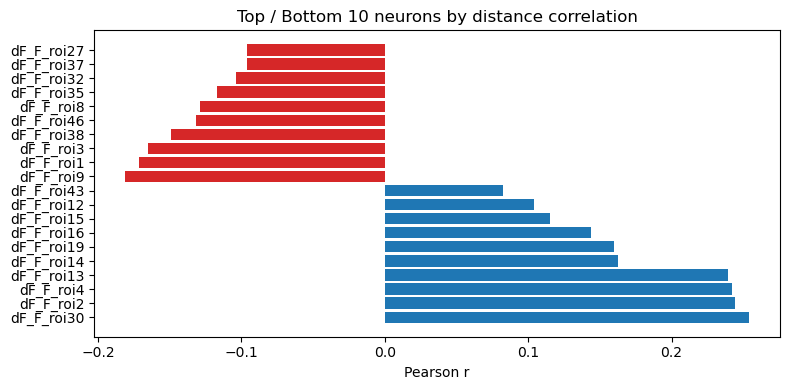

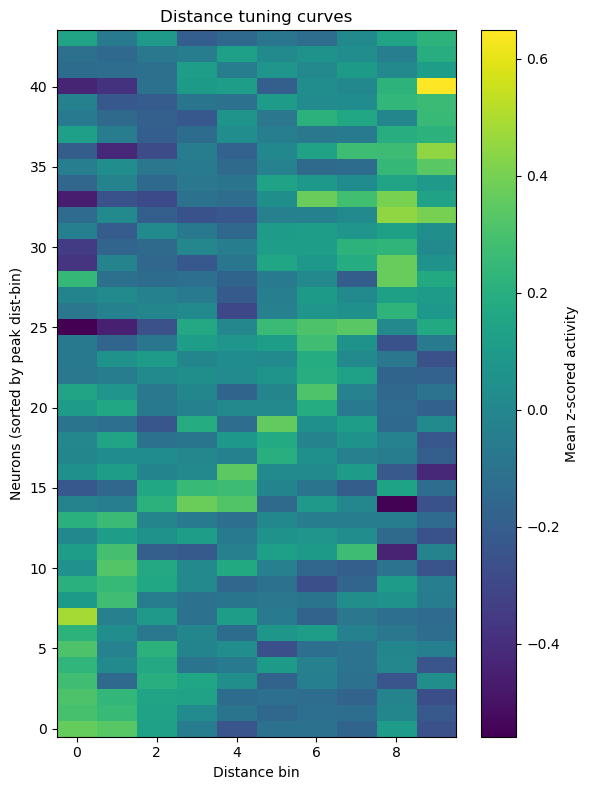

Wrote neuron_zone_stats.csv


/tmp/ipykernel_138094/4115243592.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dist_sm = pd.Series(dist).rolling(window=smooth_win,center=True).mean().fillna(method='bfill').fillna(method='ffill').to_numpy()
/tmp/ipykernel_138094/4115243592.py:49: RuntimeWarning: Mean of empty slice.
  mean_close = neuron_norm[:, is_close].mean(axis=1)
/home/lq53/miniconda3/envs/bbop241209/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_138094/4115243592.py:50: RuntimeWarning: Mean of empty slice.
  mean_mid   = neuron_norm[:, is_mid].mean(axis=1)


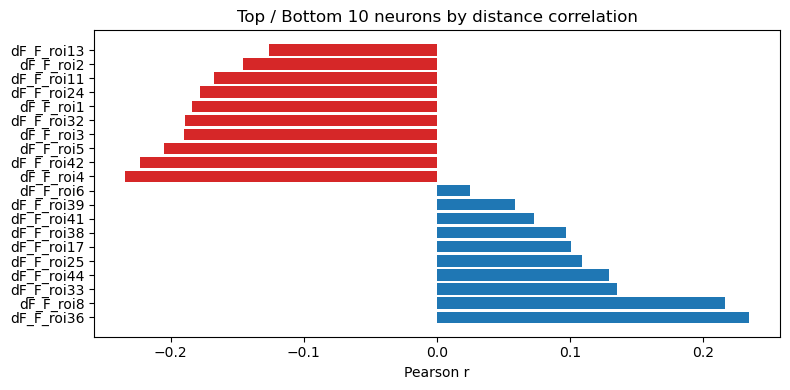

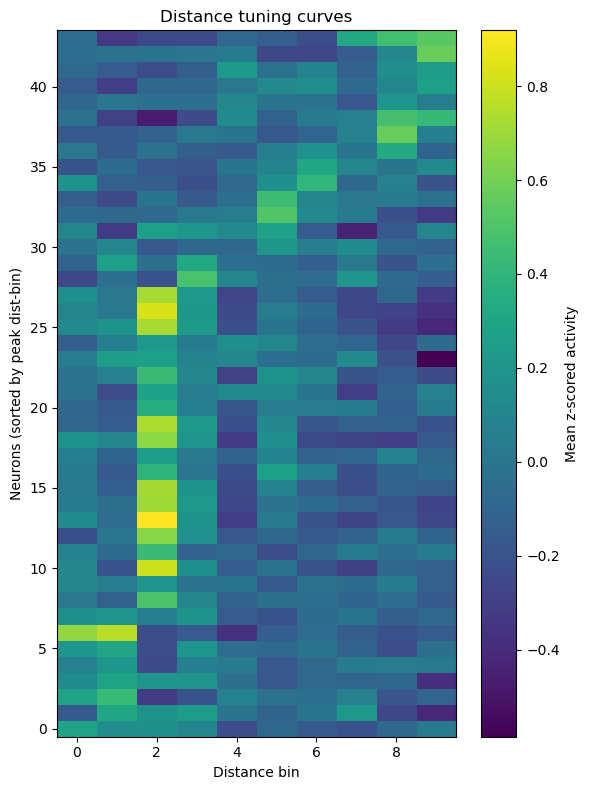

Wrote neuron_zone_stats.csv


/tmp/ipykernel_138094/4115243592.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dist_sm = pd.Series(dist).rolling(window=smooth_win,center=True).mean().fillna(method='bfill').fillna(method='ffill').to_numpy()
/tmp/ipykernel_138094/4115243592.py:49: RuntimeWarning: Mean of empty slice.
  mean_close = neuron_norm[:, is_close].mean(axis=1)
/home/lq53/miniconda3/envs/bbop241209/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_138094/4115243592.py:50: RuntimeWarning: Mean of empty slice.
  mean_mid   = neuron_norm[:, is_mid].mean(axis=1)


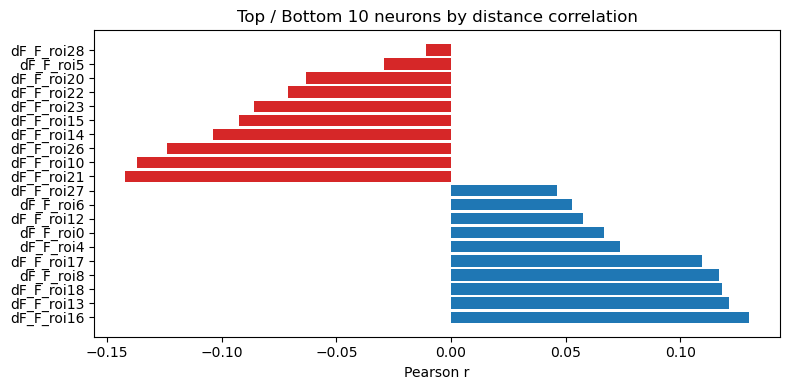

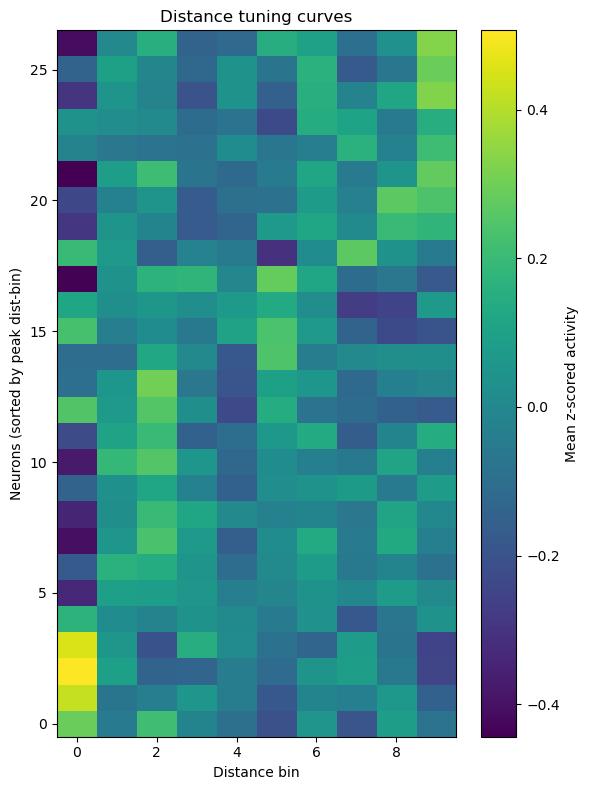

In [4]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore
from scipy.stats import pearsonr

# ----------------------------------------------------------------------------
# (1) load & process exactly as before to get neuron_norm (N×T), neuron_names, dist_sm (T,), and masks
# ----------------------------------------------------------------------------
def load_and_compute(df,
    low_th=20, high_th=60, smooth_win=5,
    exclude_dict=None, apply_exclusion=True
):
    # — neuron processing —
    neuron_norm, neuron_cols, df2 = process_neuron_activity(
        df, exclude_dict, apply_exclusion=apply_exclusion
    )
    # — time & continuous distance —
    t = df2['timestamp_ms_mini'].to_numpy()
    prefixes = sorted({c.split('_')[0] for c in df2.columns if c.startswith('com')})
    p1,p2 = prefixes[:2]
    coords = df2[[f'{p1}_x',f'{p1}_y',f'{p1}_z']].values - \
             df2[[f'{p2}_x',f'{p2}_y',f'{p2}_z']].values
    dist = np.linalg.norm(coords,axis=1)
    dist_sm = pd.Series(dist).rolling(window=smooth_win,center=True).mean().fillna(method='bfill').fillna(method='ffill').to_numpy()

    # — zone masks —
    is_close = dist_sm < low_th
    is_mid   = (dist_sm >= low_th) & (dist_sm < high_th)
    is_far   = dist_sm >= high_th

    return neuron_norm, neuron_cols, t, dist_sm, is_close, is_mid, is_far

# ----------------------------------------------------------------------------
# (2) compute per‐neuron stats & tuning
# ----------------------------------------------------------------------------
def compute_zone_stats_and_tuning(
    neuron_norm, neuron_cols,
    dist_sm, is_close, is_mid, is_far,
    n_bins=10
):
    N, T = neuron_norm.shape

    # mean per zone
    mean_close = neuron_norm[:, is_close].mean(axis=1)
    mean_mid   = neuron_norm[:, is_mid].mean(axis=1)
    mean_far   = neuron_norm[:, is_far].mean(axis=1)

    # correlation with continuous distance
    corr_dist = np.array([pearsonr(neuron_norm[i], dist_sm)[0] for i in range(N)])

    # tuning curve: bin distance into equal‐count bins
    # (you can also define fixed edges)
    bin_edges = np.quantile(dist_sm, np.linspace(0,1,n_bins+1))
    tuning = np.zeros((N, n_bins))
    for b in range(n_bins):
        mask = (dist_sm >= bin_edges[b]) & (dist_sm < bin_edges[b+1])
        if mask.sum()>0:
            tuning[:,b] = neuron_norm[:, mask].mean(axis=1)
        else:
            tuning[:,b] = np.nan

    # assemble DataFrame
    df_stats = pd.DataFrame({
        'neuron':         neuron_cols,
        'mean_close':     mean_close,
        'mean_mid':       mean_mid,
        'mean_far':       mean_far,
        'corr_distance':  corr_dist
    })
    return df_stats, tuning, bin_edges

# ----------------------------------------------------------------------------
# (3) example usage and quick plotting
# ----------------------------------------------------------------------------
session_paths = [
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
]


for path in session_paths:
    # load
    df = load_session_data(path)

    # compute
    neuron_norm, neuron_cols, t, dist_sm, close_m, mid_m, far_m = load_and_compute(
        df,
        low_th=20, high_th=60, smooth_win=5,
        exclude_dict=exclude_dict,
        apply_exclusion=False
    )
    df_stats, tuning, bins = compute_zone_stats_and_tuning(
        neuron_norm, neuron_cols, dist_sm, close_m, mid_m, far_m,
        n_bins=10
    )

    # save stats table
    out_dir = os.path.join(df['session_path'].iloc[0], 'MIR_Aligned')
    os.makedirs(out_dir, exist_ok=True)
    df_stats.to_csv(os.path.join(out_dir, 'neuron_zone_stats.csv'), index=False)
    print("Wrote neuron_zone_stats.csv")

    # --- optional quick plots ---
    # 1) bar plot of top 10 positively & negatively distance‐modulated cells
    top = df_stats.sort_values('corr_distance', ascending=False).head(10)
    bot = df_stats.sort_values('corr_distance').head(10)
    plt.figure(figsize=(8,4))
    plt.barh(top['neuron'], top['corr_distance'], color='tab:blue')
    plt.barh(bot['neuron'], bot['corr_distance'], color='tab:red')
    plt.title('Top / Bottom 10 neurons by distance correlation')
    plt.xlabel('Pearson r')
    plt.tight_layout()
    plt.show()

    # 2) heatmap of tuning curves (neurons × bins), sorted by peak bin
    peak_bin = np.nanargmax(tuning, axis=1)
    order = np.argsort(peak_bin)
    plt.figure(figsize=(6,8))
    plt.imshow(tuning[order,:], aspect='auto', origin='lower')
    plt.colorbar(label='Mean z-scored activity')
    plt.ylabel('Neurons (sorted by peak dist-bin)')
    plt.xlabel('Distance bin')
    plt.title('Distance tuning curves')
    plt.tight_layout()
    plt.show()


Processing /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/...
Saved tuning plot → /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/MIR_Aligned/tuning_2social_mini_20240819V1r1_femalebleach_11_48.png
Processing /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/...
Saved tuning plot → /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/MIR_Aligned/tuning_2social_mini_20240819V1r1_single_11_29.png
Processing /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/...
Saved tuning plot → /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/MIR_Aligned/tuning_2social_mini_20240819V1r1_AO_single_14_30.png


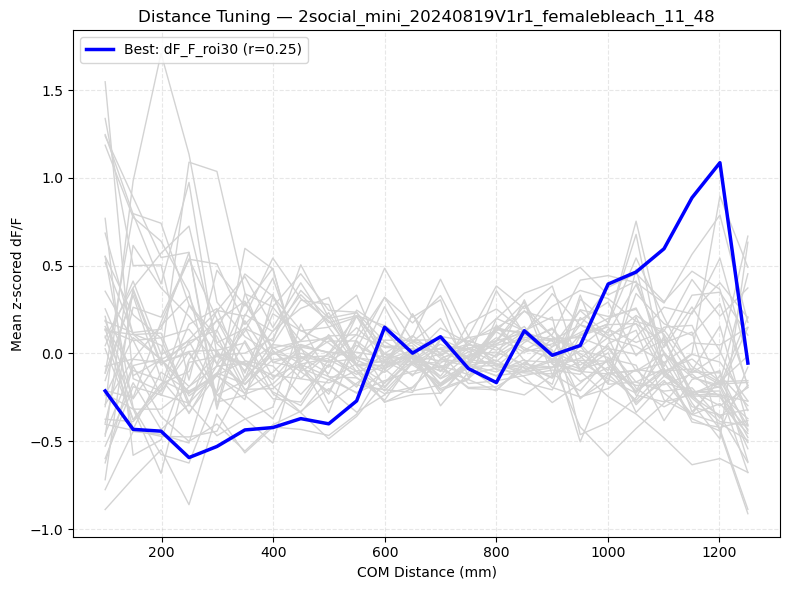

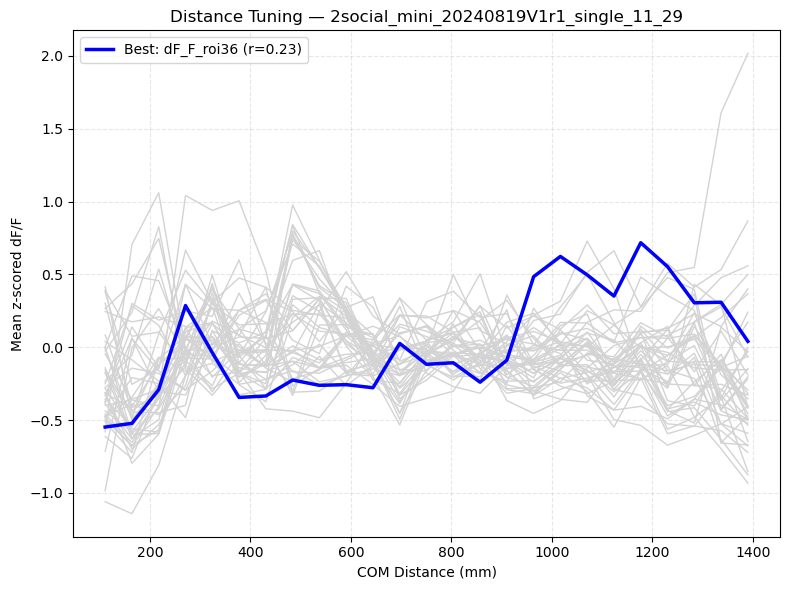

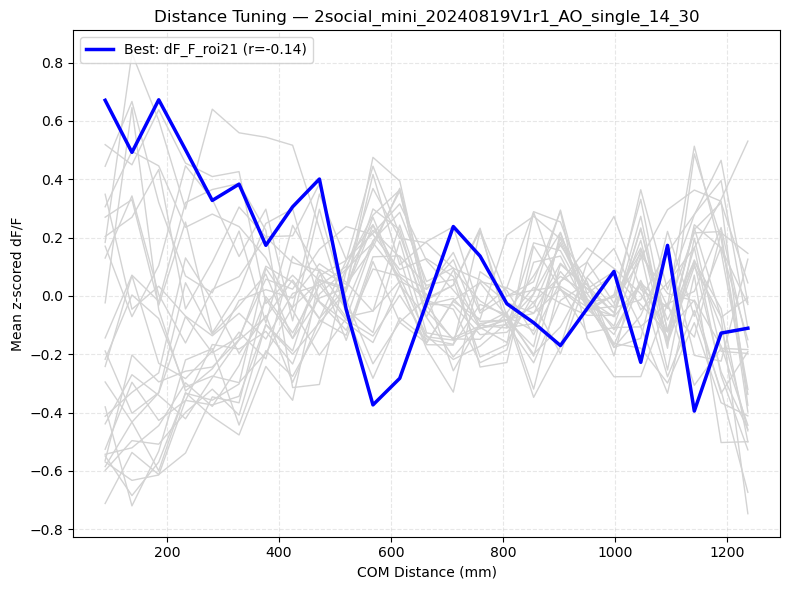

In [6]:
#!/usr/bin/env python3
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr

# ------------------------------------------------------------------------------
# 1. Load exclusion mapping
# ------------------------------------------------------------------------------
EXCLUDE_JSON = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(EXCLUDE_JSON, 'r') as f:
    EXCLUDE_DICT = json.load(f)

def get_excluded_neurons(session_path, exclude_dict):
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ------------------------------------------------------------------------------
# 2. Load session HDF5 into a DataFrame
# ------------------------------------------------------------------------------
def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    files = glob.glob(os.path.join(h5_dir, pattern))
    if not files:
        raise FileNotFoundError(f"No matching HDF5 in {h5_dir}")
    df = pd.read_hdf(files[0], key='df')
    df['session_path'] = rec_path
    return df

# ------------------------------------------------------------------------------
# 3. Process & z-score neuron activity
# ------------------------------------------------------------------------------
def process_neuron_activity(
    df,
    exclude_dict=None,
    manual_exclude=None,
    apply_exclusion=True,
    variance_percentile=5
):
    if apply_exclusion:
        if manual_exclude is not None:
            excluded = manual_exclude
        else:
            excluded = get_excluded_neurons(df['session_path'].iloc[0], exclude_dict)
    else:
        excluded = []

    # collect all dF/F columns
    cols = [c for c in df.columns if c.startswith('dF_F_roi')]
    # drop excluded
    keep = [c for c in cols if int(c.split('_')[-1][3:]) not in excluded]
    data = df[keep].values.T  # shape (n_neurons, T)

    # filter low-variance neurons
    variances = np.var(data, axis=1)
    thresh = np.percentile(variances, variance_percentile)
    mask = variances > thresh
    filtered = data[mask, :]
    normed = zscore(filtered, axis=1)
    kept_names = [n for n, m in zip(keep, mask) if m]
    return normed, kept_names, df

# ------------------------------------------------------------------------------
# 4. Compute distance tuning curves
# ------------------------------------------------------------------------------
def compute_distance_tuning(neuron_norm, dist_sm, nbins=20):
    # drop NaNs in dist_sm
    valid = ~np.isnan(dist_sm)
    dist = dist_sm[valid]
    # define bins
    edges = np.linspace(dist.min(), dist.max(), nbins + 1)
    bin_idx = np.digitize(dist, edges) - 1  # 0..nbins-1

    # compute mean activity per neuron per bin
    n_neurons = neuron_norm.shape[0]
    tuning = np.full((n_neurons, nbins), np.nan)
    for b in range(nbins):
        sel = bin_idx == b
        if sel.sum() > 0:
            tuning[:, b] = neuron_norm[:, valid][:, sel].mean(axis=1)

    # compute Pearson r with continuous distance
    corrs = np.array([
        pearsonr(neuron_norm[i, valid], dist)[0]
        for i in range(n_neurons)
    ])

    # best neuron by absolute correlation
    best = np.nanargmax(np.abs(corrs))
    centers = (edges[:-1] + edges[1:]) / 2
    return tuning, centers, best, corrs

# ------------------------------------------------------------------------------
# 5. Plot tuning curves
# ------------------------------------------------------------------------------
def plot_distance_tuning(
    neuron_norm,
    neuron_names,
    dist_sm,
    session_name,
    nbins=20,
    out_dir=None
):
    tuning, centers, best_idx, corrs = compute_distance_tuning(neuron_norm, dist_sm, nbins)

    fig, ax = plt.subplots(figsize=(8, 6))
    # all neurons in light gray
    for i in range(tuning.shape[0]):
        ax.plot(centers, tuning[i], color='lightgray', linewidth=1)
    # highlight best
    ax.plot(
        centers,
        tuning[best_idx],
        color='blue',
        linewidth=2.5,
        label=f'Best: {neuron_names[best_idx]} (r={corrs[best_idx]:.2f})'
    )
    ax.set_xlabel('COM Distance (mm)')
    ax.set_ylabel('Mean z-scored dF/F')
    ax.set_title(f'Distance Tuning — {session_name}')
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()

    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
        fname = f"tuning_{session_name}.png"
        plt.savefig(os.path.join(out_dir, fname), dpi=300)
        print(f"Saved tuning plot → {os.path.join(out_dir, fname)}")
    else:
        plt.show()

# ------------------------------------------------------------------------------
# 6. Main routine
# ------------------------------------------------------------------------------
def main():
    # list your session folders here
    session_paths = [
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
    ]


    for path in session_paths:
        print(f"Processing {path}...")
        df = load_session_data(path)
        neuron_norm, neuron_names, df = process_neuron_activity(
            df, exclude_dict=EXCLUDE_DICT, apply_exclusion=False
        )

        # compute smoothed inter-COM distance
        prefixes = sorted({c.split('_')[0] for c in df.columns if c.startswith('com')})
        if len(prefixes) < 2:
            print("  Skipping: need at least two COM prefixes")
            continue
        p1, p2 = prefixes[:2]
        coords = df[[f'{p1}_x', f'{p1}_y', f'{p1}_z']].values \
               - df[[f'{p2}_x', f'{p2}_y', f'{p2}_z']].values
        dist = np.linalg.norm(coords, axis=1)
        dist_sm = pd.Series(dist).rolling(window=5, center=True).mean().to_numpy()

        # plot & save
        session_name = os.path.basename(os.path.normpath(path))
        out_dir = os.path.join(path, 'MIR_Aligned')
        plot_distance_tuning(
            neuron_norm,
            neuron_names,
            dist_sm,
            session_name=session_name,
            nbins=25,
            out_dir=out_dir
        )

if __name__ == '__main__':
    main()


NameError: name 'neuron_names' is not defined